## Дообученная на наших данных Rosetta

Возьмём предобученную модель Rosetta: ResNet + None + CTC (отсюда https://github.com/clovaai/deep-text-recognition-benchmark). И дообучим её на наших данных.

In [ ]:
!pip3 install torch==1.3.1

     |████████████████████████████████| 734.6 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.3.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.3.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.3.1 which is incompatible.


In [ ]:
!pip3 install lmdb pillow torchvision nltk natsort

     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [ ]:
!git clone https://github.com/clovaai/deep-text-recognition-benchmark.git

Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (301/301), done.


Сначала просто запустим её на примере картинки:

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python3 deep-text-recognition-benchmark/demo.py \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--image_folder deep-text-recognition-benchmark/demo_image/ \
--saved_model drive/MyDrive/pretrained_models/None-ResNet-None-CTC.pth

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
No Transformation module specified
No SequenceModeling module specified
model input parameters 32 100 20 1 512 256 37 25 None ResNet None CTC
loading pretrained model from drive/MyDrive/pretrained_models/None-ResNet-None-CTC.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
---------------------------------------------------------------

Перейдём к fine-tuning-у модели. Для этого сначала переведём наш датасет в необходимый lmdb-формат:

In [ ]:
TEST_GT = '/content/drive/MyDrive/recognition_dataset/test_img/test_gt.txt'
TRAIN_GT = '/content/drive/MyDrive/recognition_dataset/train_img/train_gt.txt'

NEW_TEST_GT = '/content/drive/MyDrive/recognition_dataset/test_img/gt.txt'
NEW_TRAIN_GT = '/content/drive/MyDrive/recognition_dataset/train_img/gt.txt'

In [ ]:
def create_good_gt_file(curr_file_path, new_file_path, folder_name):
  new_lines = []
  with open(curr_file_path) as f:
    for line in f.readlines():
      new_lines.append(line.replace('"', '').replace(',', '').replace(' ', '\t'))
  with open(new_file_path, 'w') as f:
    for line in new_lines:
      f.write(folder_name + '/' + line)

In [ ]:
create_good_gt_file(TEST_GT, NEW_TEST_GT, 'test')
create_good_gt_file(TRAIN_GT, NEW_TRAIN_GT, 'train')

In [ ]:
!pip3 install fire

In [ ]:
!python3 deep-text-recognition-benchmark/create_lmdb_dataset.py \
--inputPath drive/MyDrive/recognition_dataset/train_img \
--gtFile drive/MyDrive/recognition_dataset/train_img/gt.txt --outputPath ./train_dataset/

Created dataset with 164 samples


In [ ]:
!python3 deep-text-recognition-benchmark/create_lmdb_dataset.py \
--inputPath drive/MyDrive/recognition_dataset/test_img \
--gtFile drive/MyDrive/recognition_dataset/test_img/gt.txt --outputPath ./test_dataset/

Created dataset with 41 samples


In [41]:
!CUDA_VISIBLE_DEVICES=0 python3 deep-text-recognition-benchmark/train.py \
--train_data ./train_dataset --valid_data ./test_dataset \
--select_data / --batch_ratio 1 \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--saved_model drive/MyDrive/pretrained_models/None-ResNet-None-CTC.pth \
--batch_size 16 --workers 1

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: ./train_dataset
opt.select_data: ['/']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    ./train_dataset	 dataset: /
sub-directory:	/.	 num samples: 164
num total samples of /: 164 x 1.0 (total_data_usage_ratio) = 164
num samples of / per batch: 16 x 1.0 (batch_ratio) = 16
--------------------------------------------------------------------------------
Total_batch_size: 16 = 16
----------------------------------------------------------

Посмотрим, какие результаты на тестовых картинках даёт эта модель (ограничимся только цифрами!):

In [49]:
!CUDA_VISIBLE_DEVICES=0 python3 deep-text-recognition-benchmark/demo.py \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--image_folder drive/MyDrive/recognition_dataset/test_img/test \
--saved_model /content/saved_models/None-ResNet-None-CTC-Seed1111/best_accuracy.pth

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
No Transformation module specified
No SequenceModeling module specified
model input parameters 32 100 20 1 512 256 37 25 None ResNet None CTC
loading pretrained model from /content/saved_models/None-ResNet-None-CTC-Seed1111/best_accuracy.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
--------------------------------------------------

In [43]:
import matplotlib.pyplot as plt

def visualize(image, prediction, confidence):
    plt.figure(figsize=(10, 10))
    plt.title('Prediction: %s, confidence: %.3f' % (prediction, confidence))
    plt.axis('off')
    plt.imshow(image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


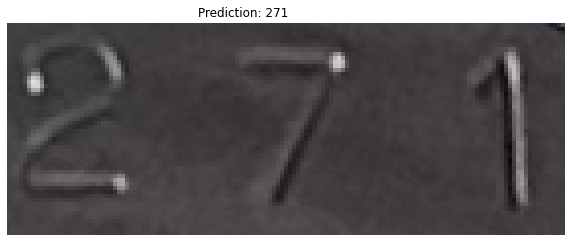

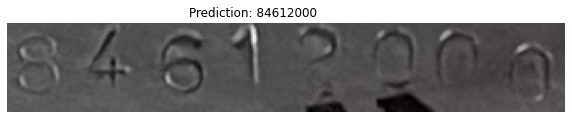

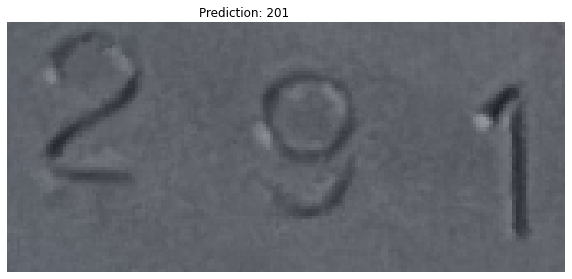

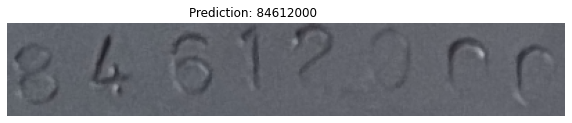

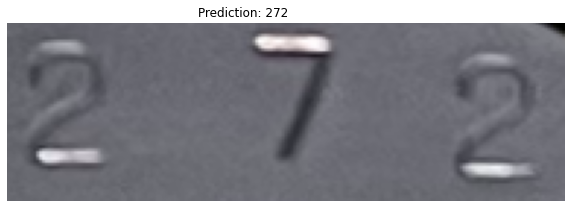

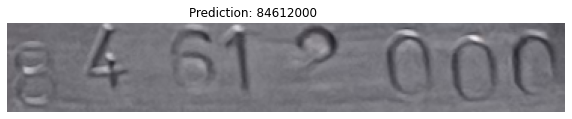

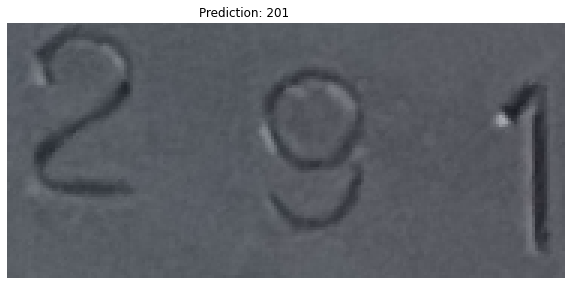

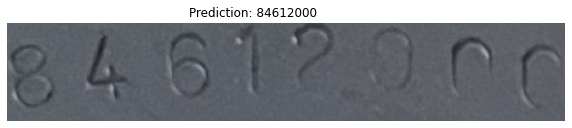

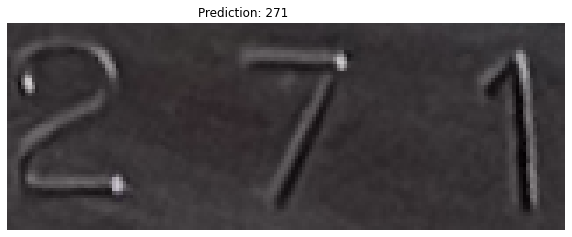

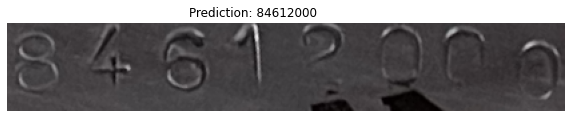

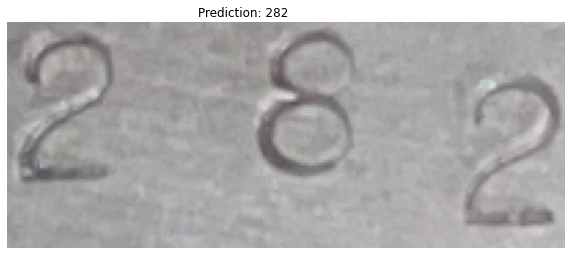

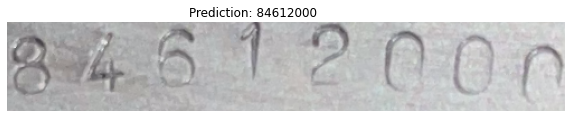

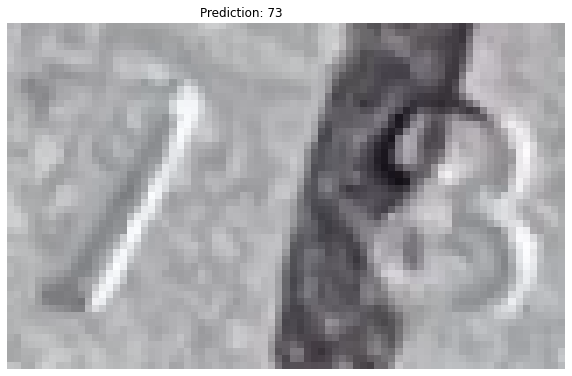

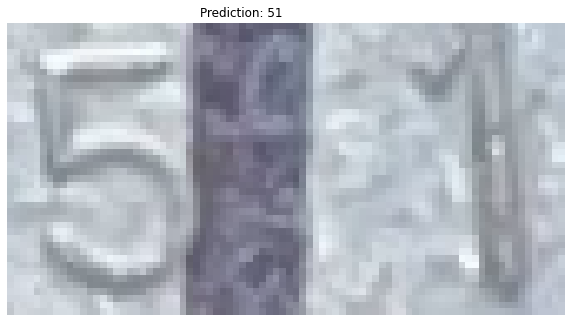

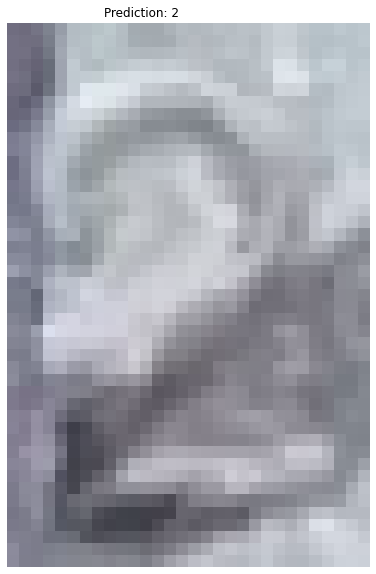

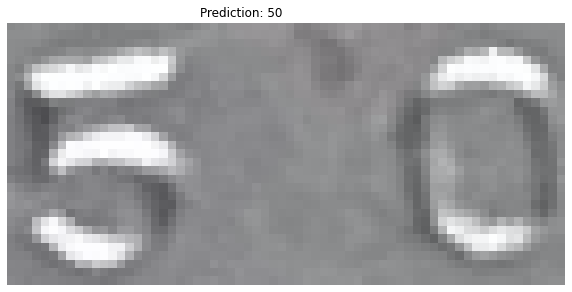

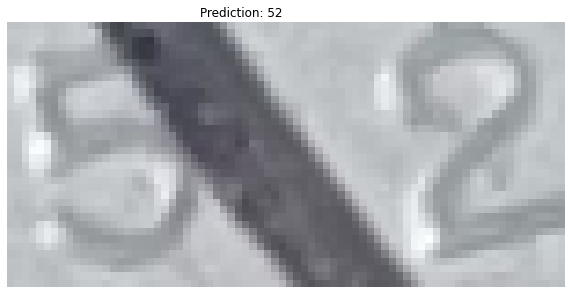

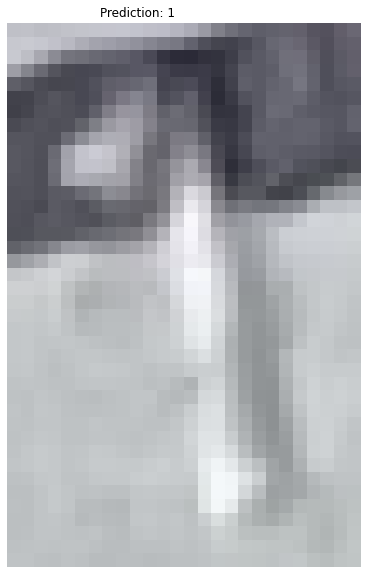

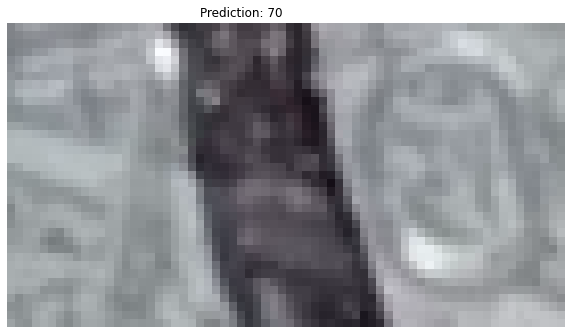

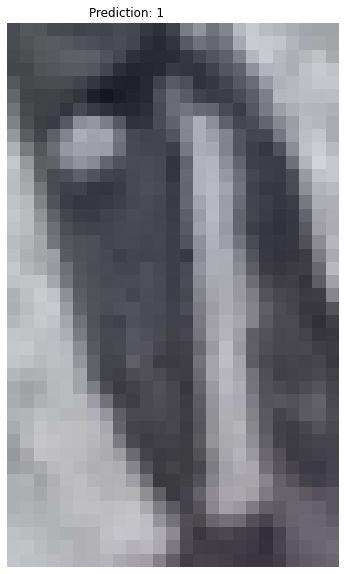

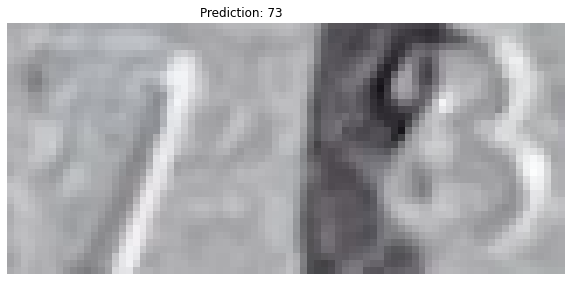

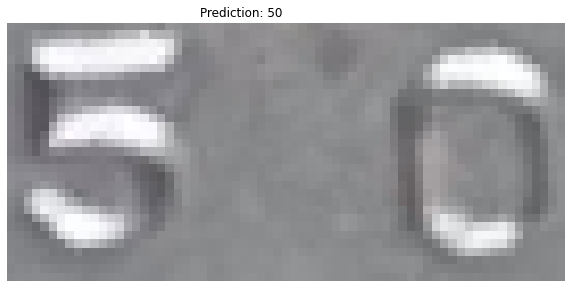

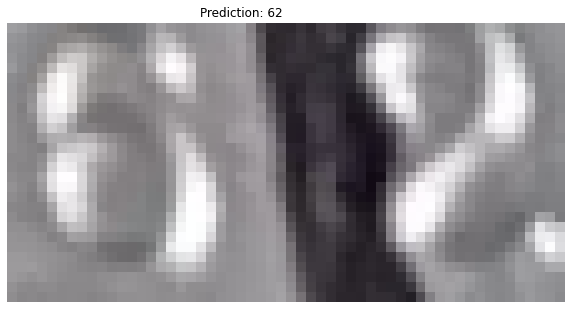

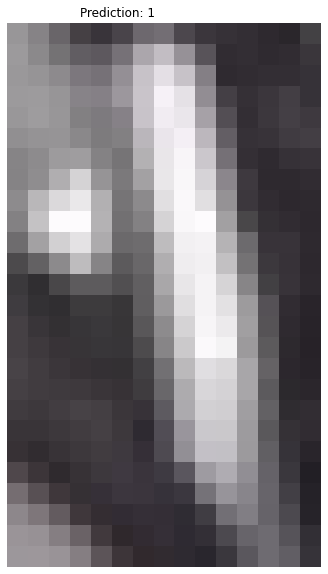

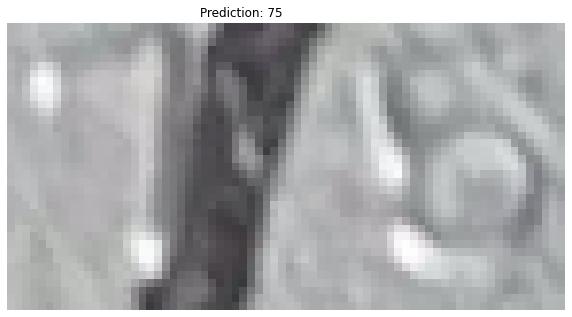

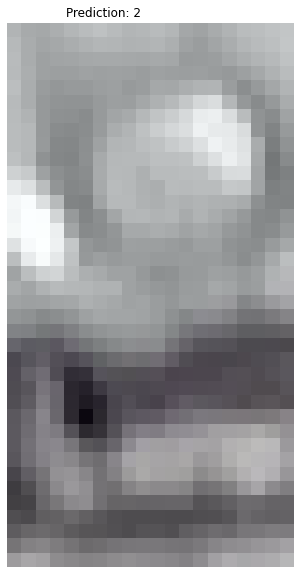

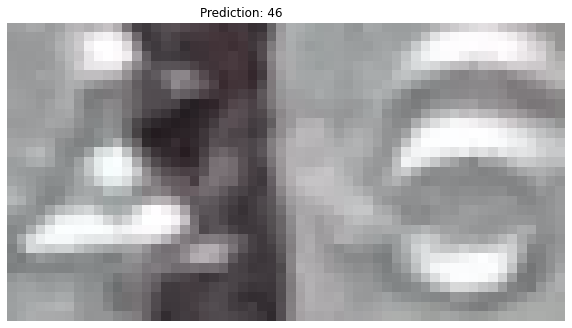

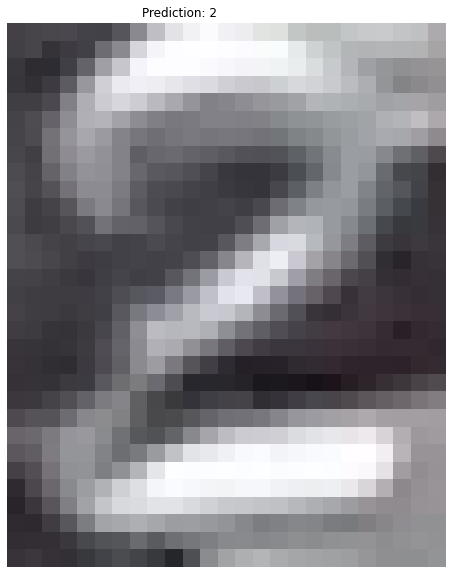

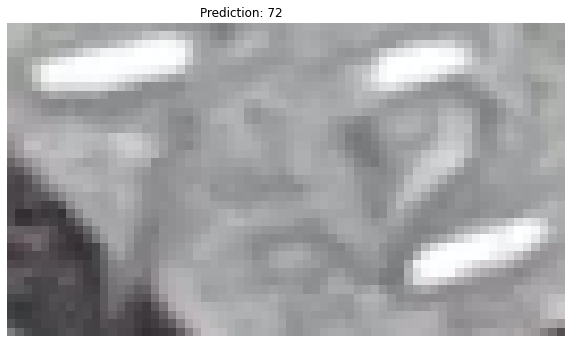

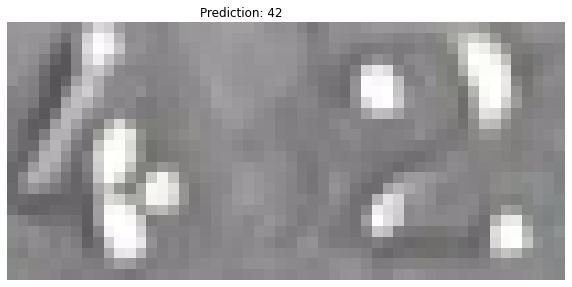

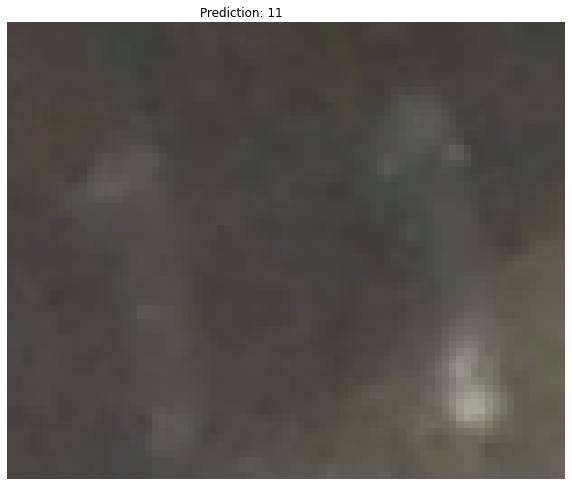

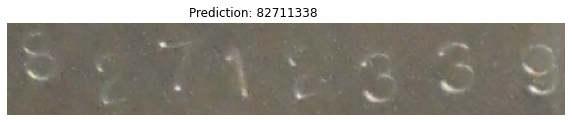

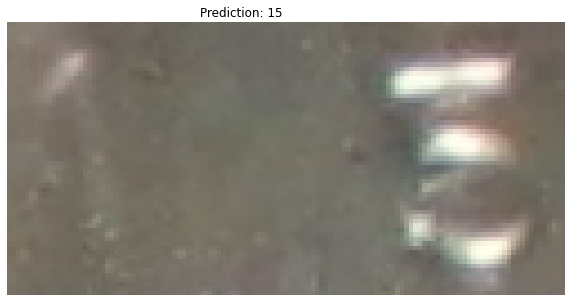

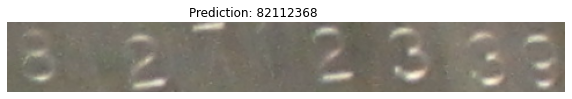

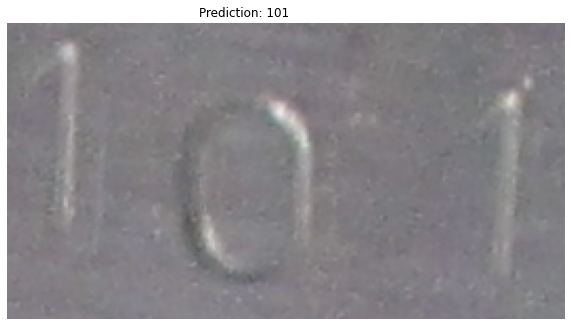

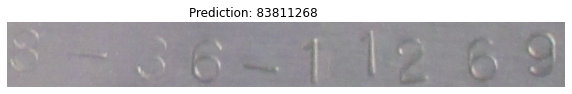

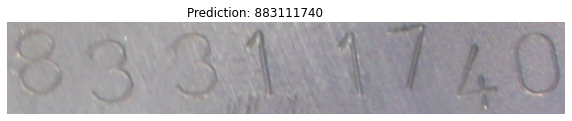

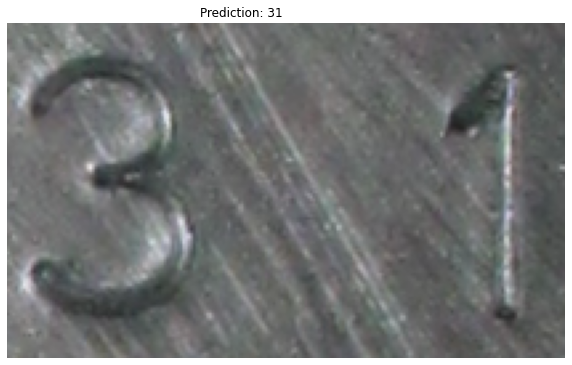

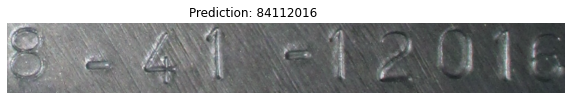

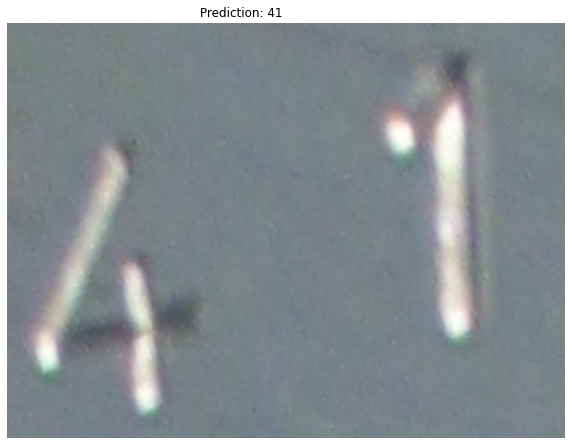

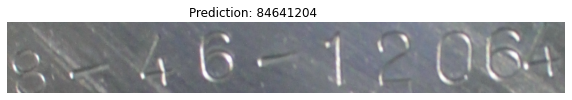

In [50]:
import cv2

with open('log_demo_result.txt') as f:
  for i, line in enumerate(f.readlines()):
    if i < 74:
      continue
    if len(line.split('\t')) == 3:
      img_path, prediction, conf = line.split('\t')
    else:
      img_path, conf = line.replace('\t', '')
      prediction = ''
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualize(img, prediction)

Проведём ещё один эксперимент: добавим в обучающую выборку нагенерированные GAN строчки с номерами. Посмотрим, что получится:

In [48]:
!python3 deep-text-recognition-benchmark/create_lmdb_dataset.py \
--inputPath drive/MyDrive/recognition_dataset/train_and_gan \
--gtFile drive/MyDrive/recognition_dataset/train_and_gan/whole_gt.txt --outputPath ./train_and_gan_dataset/

Written 1000 / 1164
Created dataset with 1164 samples


In [51]:
!CUDA_VISIBLE_DEVICES=0 python3 deep-text-recognition-benchmark/train.py \
--train_data ./train_and_gan_dataset --valid_data ./test_dataset \
--select_data / --batch_ratio 1 \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--saved_model drive/MyDrive/pretrained_models/None-ResNet-None-CTC.pth \
--batch_size 16 --workers 1

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: ./train_and_gan_dataset
opt.select_data: ['/']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    ./train_and_gan_dataset	 dataset: /
sub-directory:	/.	 num samples: 1164
num total samples of /: 1164 x 1.0 (total_data_usage_ratio) = 1164
num samples of / per batch: 16 x 1.0 (batch_ratio) = 16
--------------------------------------------------------------------------------
Total_batch_size: 16 = 16
---------------------------------------

In [52]:
!CUDA_VISIBLE_DEVICES=0 python3 deep-text-recognition-benchmark/demo.py \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--image_folder drive/MyDrive/recognition_dataset/test_img/test \
--saved_model /content/saved_models/None-ResNet-None-CTC-Seed1111/best_accuracy.pth

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
No Transformation module specified
No SequenceModeling module specified
model input parameters 32 100 20 1 512 256 37 25 None ResNet None CTC
loading pretrained model from /content/saved_models/None-ResNet-None-CTC-Seed1111/best_accuracy.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
--------------------------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


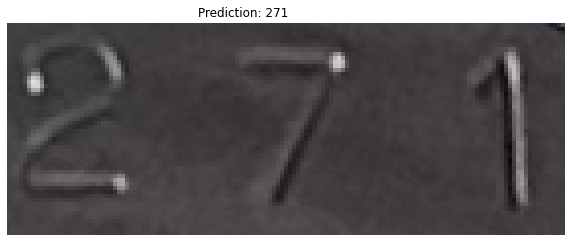

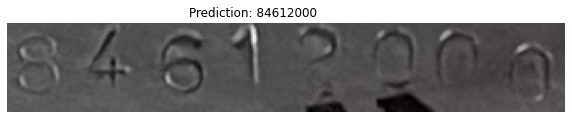

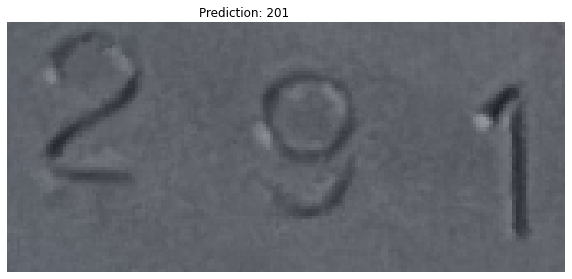

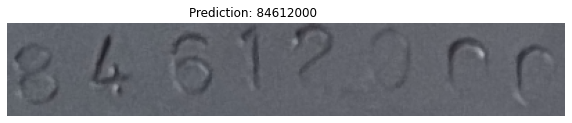

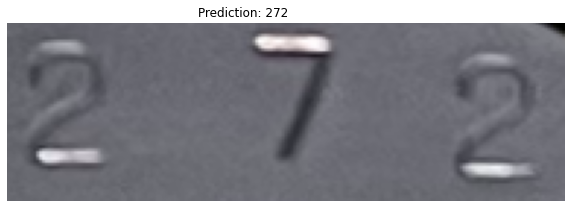

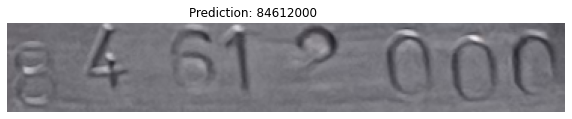

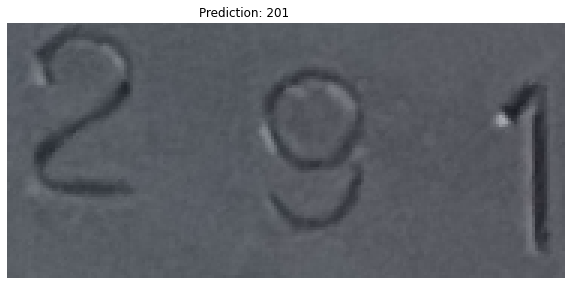

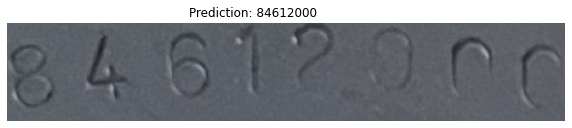

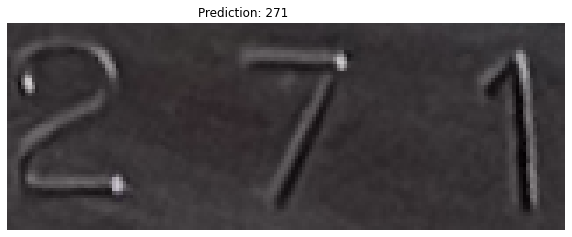

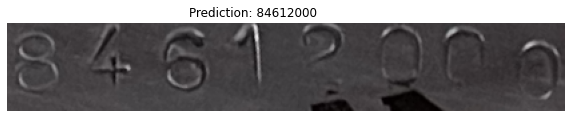

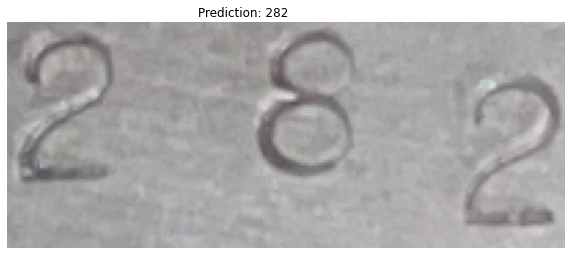

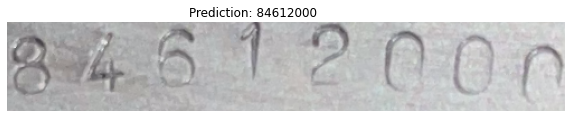

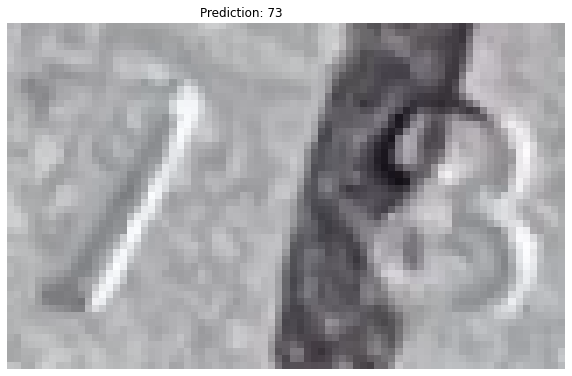

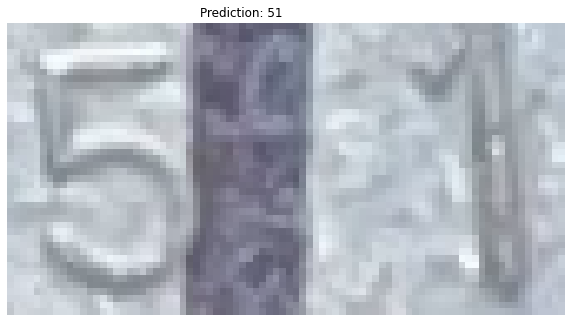

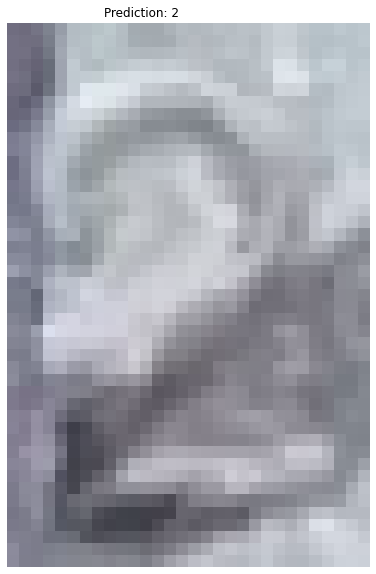

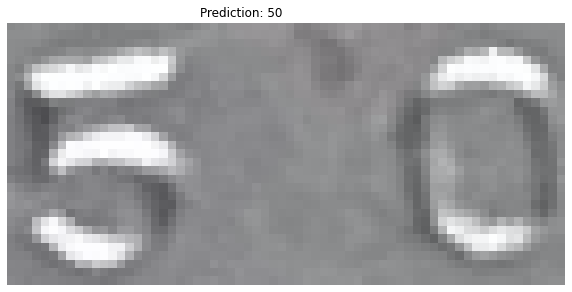

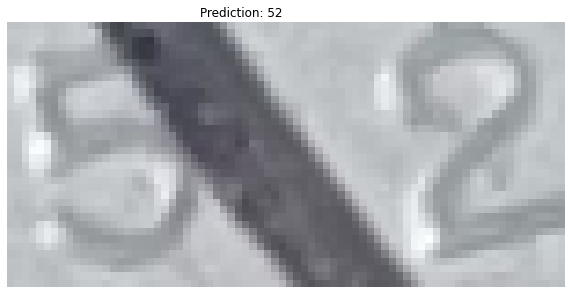

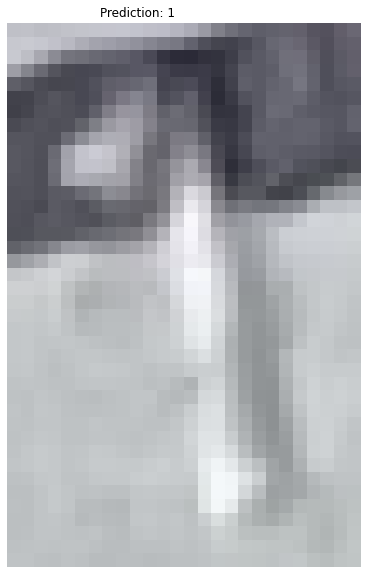

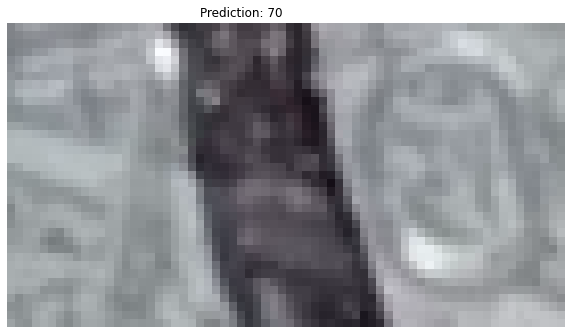

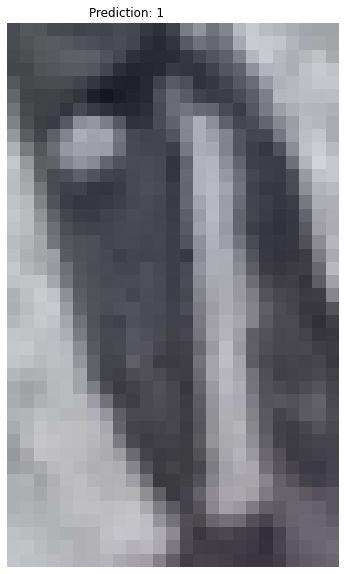

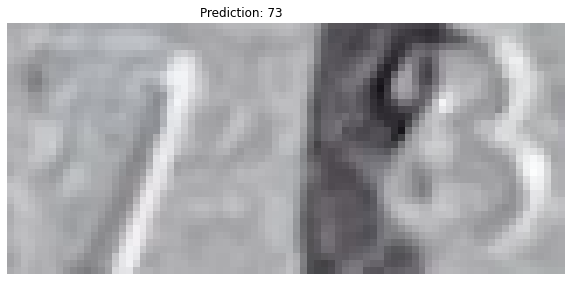

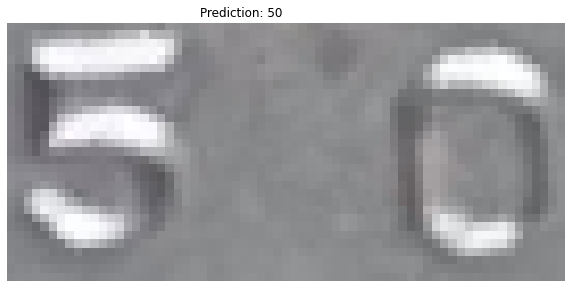

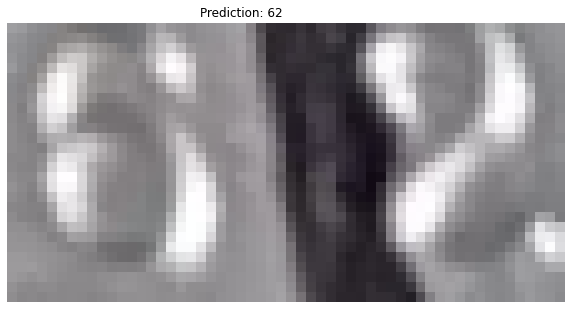

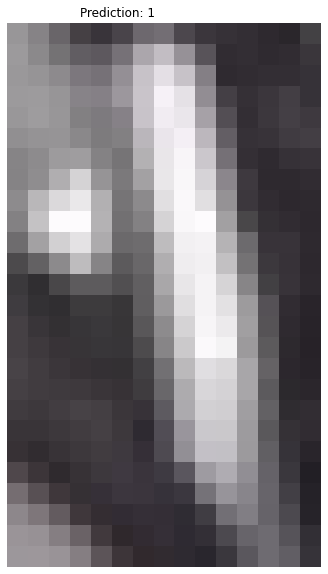

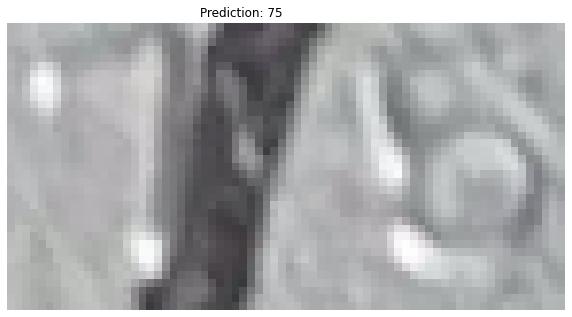

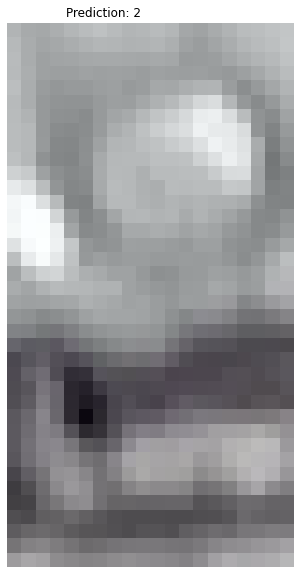

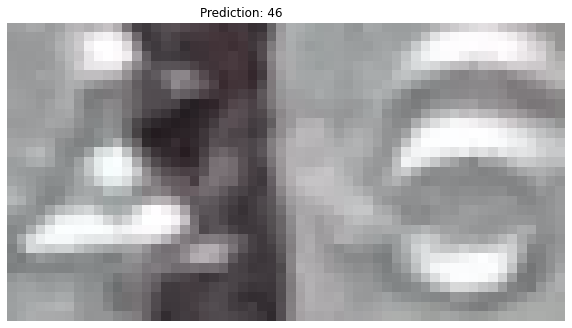

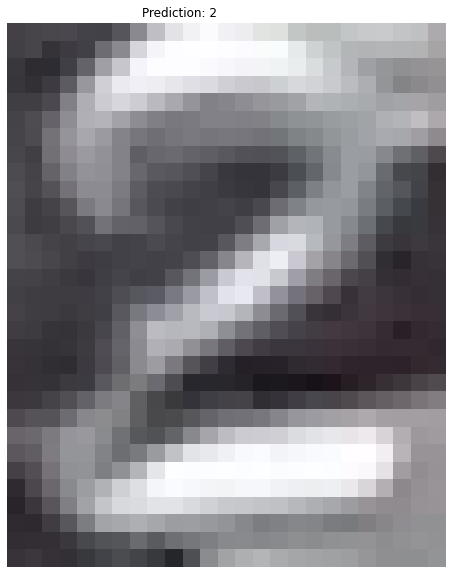

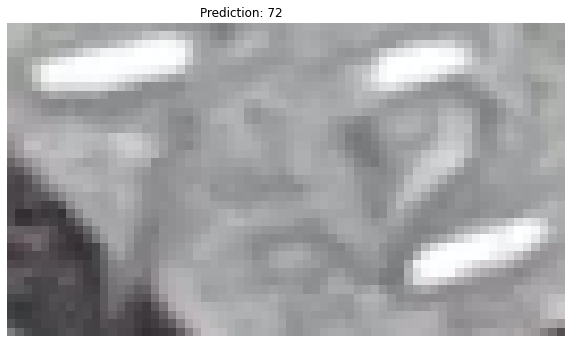

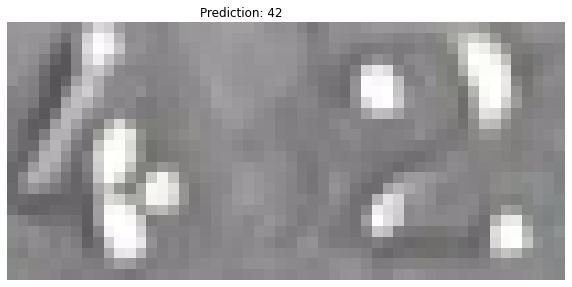

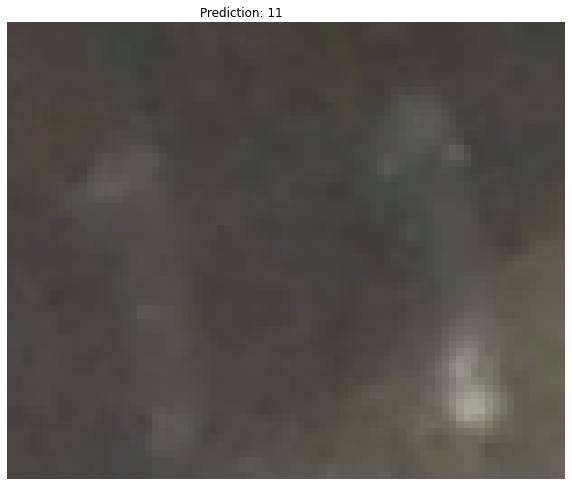

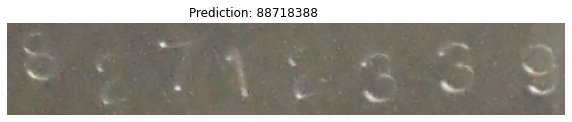

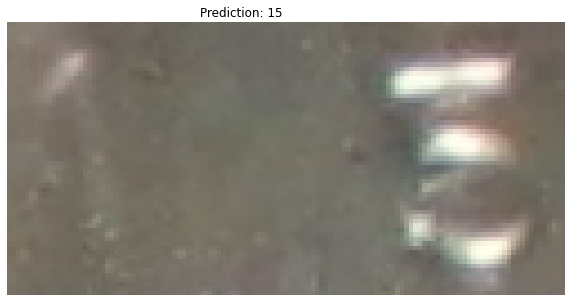

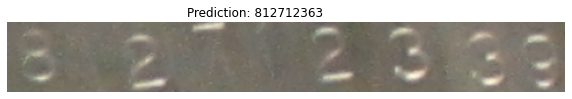

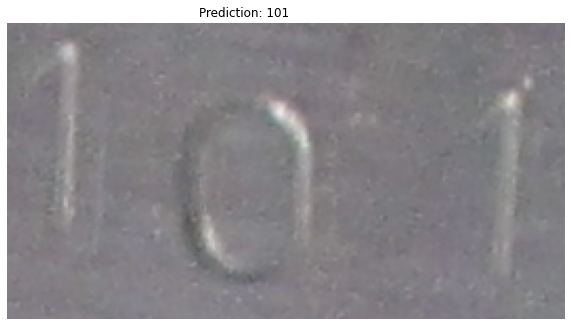

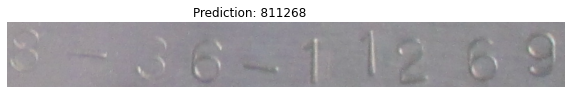

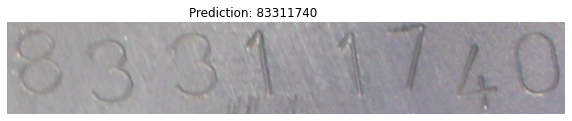

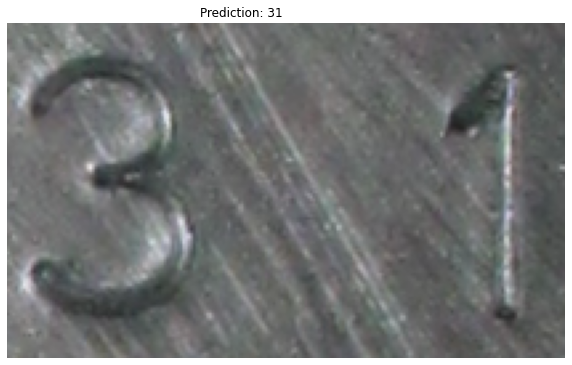

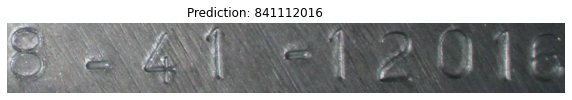

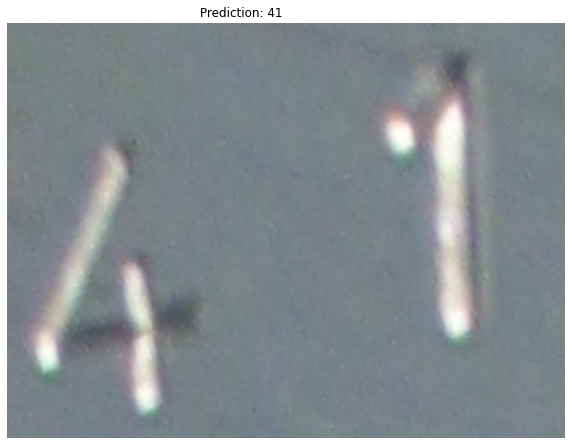

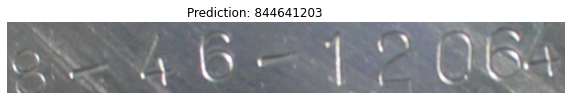

In [53]:
with open('log_demo_result.txt') as f:
  for i, line in enumerate(f.readlines()):
    if i < 118:
      continue
    if len(line.split('\t')) == 3:
      img_path, prediction, conf = line.split('\t')
    else:
      img_path, conf = line.replace('\t', '')
      prediction = ''
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualize(img, prediction)